## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
# import all required libraries
import numpy as np
import cv2
import glob
import math
import time
import pickle
import itertools
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from multi_plot import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import scipy.ndimage as snd
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

%matplotlib inline

#### Load all "car" and "non-car" files and show some examples

Number of car files:  8807
Number of non-car files:  8968


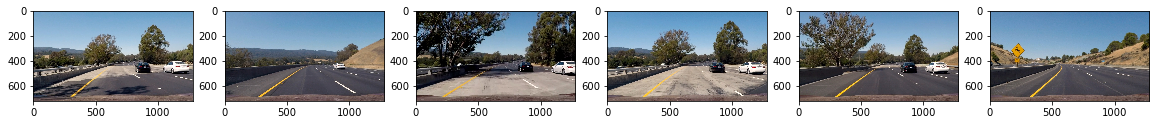

In [2]:
test_files = glob.glob('./test_images/*.jpg')
car_files = glob.glob('vehicles/**/*.png', recursive=True)
print("Number of car files: ", len(car_files))
notcar_files = glob.glob('non_vehicles/**/*.png', recursive=True)
print("Number of non-car files: ", len(notcar_files))
output_folder = './output_images/'

test_images = []
for fname in test_files:
    img = snd.imread(fname)
    test_images.append(img)
    
plot_images(test_images, n_cols=6)

#### In this cell we use the functions from `feature_extraction.py` to explore the HOG features. By applying the HOG operation the image is divided in smaller cells and the magnitude of gradients in these cells is calculated and all of these gradients will be used as features.

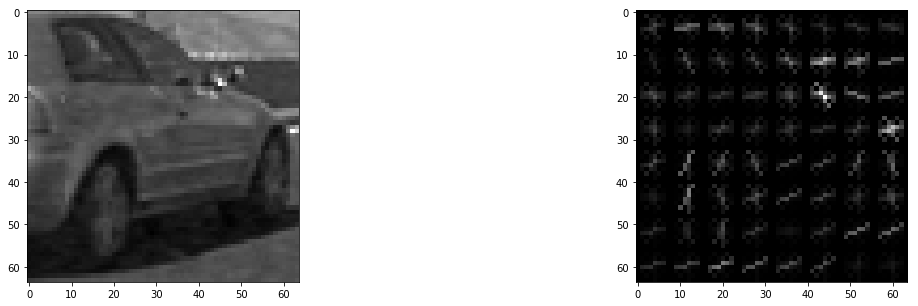

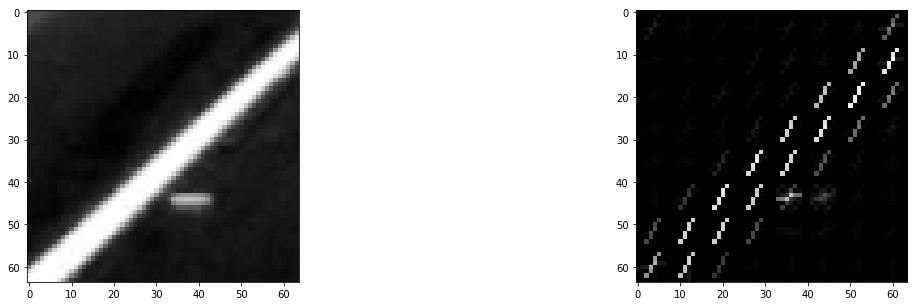

In [3]:
%run feature_extraction.py

example_cars = [snd.imread(file)[:,:,0] for file in car_files[1:2]]
example_notcars = [snd.imread(file)[:,:,0] for file in notcar_files[1:2]]

example_hog_cars=[]
example_hog_notcars=[]
for img in example_cars:
    hog_features, hog_img = get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    example_hog_cars.append(hog_img)
    
for img in example_notcars:
    hog_features, hog_img = get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    example_hog_notcars.append(hog_img)

plot_compare_images(example_cars, example_hog_cars, cmap='gray')
plot_compare_images(example_notcars, example_hog_notcars, cmap='gray')

In [4]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
svc = None
X_Scaler = None

#### A linear SVM is trained here. I used the provided images from the course and used the same amount of "car" and "not car" images. The `StandardScaler` scikit-learn library normalizes the data and the `train_test_split` function shuffle and split the data in 80% training and 20% test data. With the described parameters we got a test accuracy of 99%. Here you can see an example of unnormalized and normalized data:


In [ ]:
%run feature_extraction.py
# Reduce the sample size to speed up for fast test
sample_size = min(len(car_files), len(notcar_files))
print("Sample size:", sample_size)
cars = car_files[0:sample_size]
notcars = notcar_files[0:sample_size]

def train_svc():
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    X = np.vstack((car_features, notcar_features)).astype(np.float32) 
    print(X.shape)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    del X

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    return svc, X_scaler

svc, X_scaler = train_svc()

#### Here we can save and load our SVM

In [5]:
# save SVM data
def save_classifier(file='svm.p'):
    print('Saving classification data to pickle file...')
    try:
        with open(file, 'wb') as pfile:
            pickle.dump(
                {   'svc':svc, 
                    'X_scaler': X_scaler,
                    'color_space': color_space,
                    'spatial_size': spatial_size,
                    'hist_bins': hist_bins,
                    'orient': orient,
                    'pix_per_cell': pix_per_cell,
                    'cell_per_block': cell_per_block,
                    'hog_channel': hog_channel,
                    'spatial_feat': spatial_feat,
                    'hist_feat': hist_feat,
                    'hog_feat':hog_feat
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Error saving pickle file', file, ':', e)
        raise
        
def load_classifier(file='svm.p'):
    global svc, X_scaler, spatial_size, hist_bins, orient, pix_per_cell
    global cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat
    print('Load classification data from pickle file...')
    try:
        with open(file, "rb") as pfile:
            data = pickle.load(pfile)
            svc = data['svc']
            X_scaler = data['X_scaler']
            spatial_size =  data['spatial_size']
            hist_bins = data['hist_bins']
            orient = data['orient']
            pix_per_cell = data['pix_per_cell']
            cell_per_block = data['cell_per_block']
            hog_channel = data['hog_channel']
            spatial_feat = data['spatial_feat']
            hist_feat = data['hist_feat']
            hog_feat = data['hog_feat']         
                
    except Exception as e:
        print('Error loading pickle file', file, ':', e)
        raise   
load_classifier("svm_YCrCb.p")

Load classification data from pickle file...


(1, 6156)


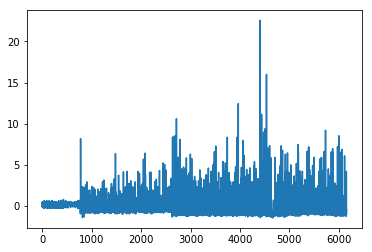

2.7 Seconds to find car windows...


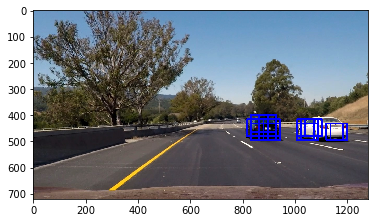

In [6]:
%run feature_extraction.py
image = snd.imread(test_files[4])
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop = [400, 600] # Min and max in y to search in slide_window()
window_sizes=[(64, 128)]

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))


windows = []
for w in range(64, 128, 64):
    win = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, \
                       xy_window=(w, w), xy_overlap=(0.75, 0.75))
    windows += win
    
t=time.time()
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find car windows...')

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

#### Sliding window search
From the test images you can see that the street starts around 400+ in y direction and cars are passing till 600. Therefore the search area in the y direction is restricted to this area. There is no restriction in x direction.
For the search I use quadratic windows with sizes from 128x128 in the bottom of this area to 64x64 in the top. In the example below the function `slide_window` (feature_extraction.py: line 146) provided by the course is used to display these windows. When I used smaller windows also in the bottom I got more false positives on the lanes. The overlap of 75% got much better results 0% or 50% overlap.

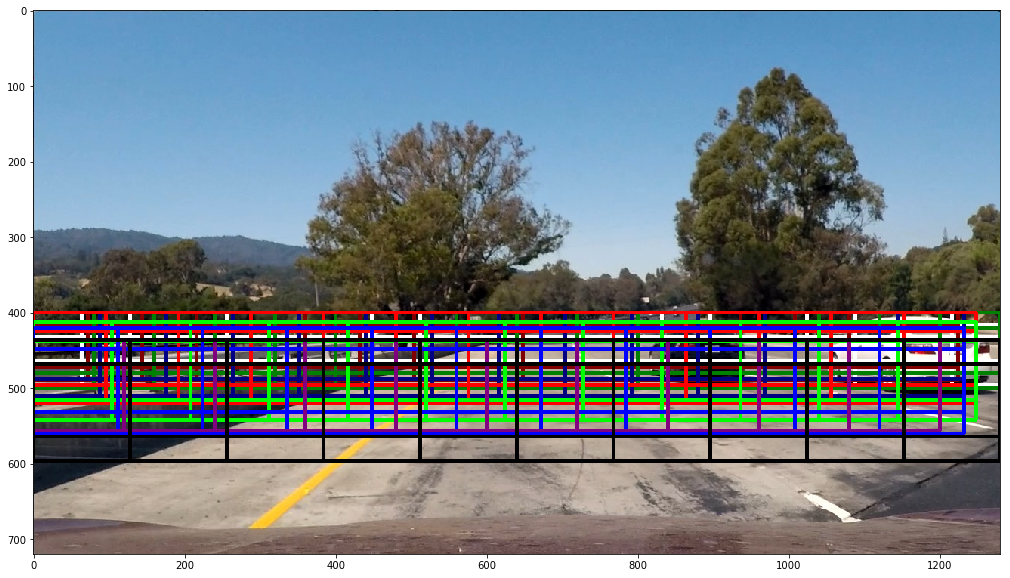

In [7]:
image = snd.imread(test_files[3])
window_scales = np.linspace(1.,2.,9)
#start_stop = [[400,496],[400,496],[400,512],[400,512],[400,528],[400,528],[400,544],[400,544],\
#              [436,560],[436,600]]
start_stop = [[400,496],[400,496],[400,512],[400,512],[400,528],[412,544],[420,560],\
              [436,560],[436,600]]

color = [(255,255,255),(128,0,0),(0,128,0),(0,0,128),(255,0,0),(0,255,0),(0,0,255),(128,0,128),(0,0,0)]
    
for i,scale in enumerate(window_scales):
    search_windows = slide_window(image, y_start_stop=start_stop[i], \
                                  xy_window=(int(64*scale),int(64*scale)), xy_overlap=(0.,0.75))
    for w in search_windows:
        image = cv2.rectangle(image, w[0], w[1], color[i], 3)

plt.figure(figsize=(20,10))
plt.imshow(image)

#### Processing image function to draw vehicle detected boxes

In [9]:
image = snd.imread(test_files[3])
car_boxes = Box(image)

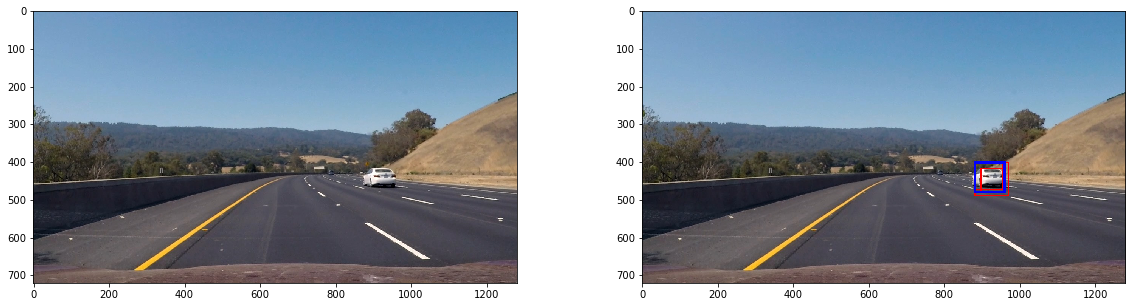

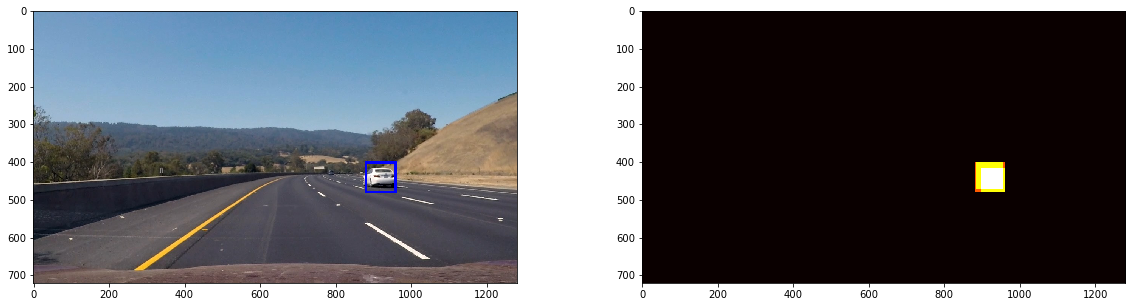

In [12]:
%run feature_extraction.py
%run box.py

image = snd.imread(test_files[1])
window_scales = np.linspace(1.,2.,9)

def process_image(image, draw_boxes=False):
    draw_image = np.copy(image)
    hot_boxes = []
    for i,scale in enumerate(window_scales):
        out_img, boxes = find_cars(image, start_stop[i][0], start_stop[i][1], scale, \
                                     svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        hot_boxes += boxes
    car_boxes.add_boxes(hot_boxes)
    if draw_boxes is True:
        draw_image = car_boxes.draw_hot(draw_image)
    return car_boxes.draw_final(draw_image)

box_final_img = process_image(image)
box_img = process_image(image, draw_boxes=True)
#print(max(car_boxes.avg_heatmap[np.nonzero(car_boxes.avg_heatmap)]))

plot_compare_images([image], [box_img], savefig='box_final.png')
plot_compare_images([box_final_img], [car_boxes.avg_heatmap], cmap='hot', savefig='heatmap_2.png')

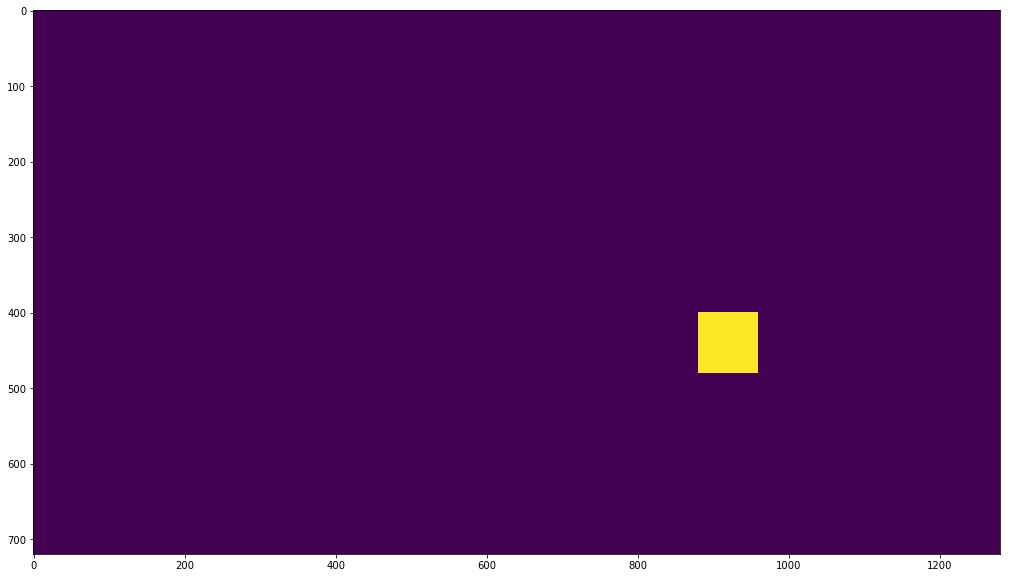

In [13]:
# plot labels
plt.figure(figsize=(20,10))
plt.imshow(car_boxes.labels[0])
plt.savefig('labels.png')

### Video output

In [ ]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)#.subclip(27,31)
white_clip = clip1.fl_image(process_image)
#white_clip.write_images_sequence("scene%i.jpg")
%time white_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))